In [2]:
import sys
sys.path.append('/home/gridsan/swagata/Atomistic-Adversarial-Attacks/')
sys.path.append('/home/gridsan/swagata/NeuralForceField/')
import robust as rb
import torch as ch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import copy
from nff.nn.tensorgrad import compute_grad
from torch.optim import Adam
from torch.utils.data.sampler import RandomSampler
from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, metrics, evaluate
from nff.train import hooks as nff_hook
from scipy import stats
from ase import units
from matplotlib import cm
import matplotlib.pyplot as plt
from ase.md.md import MolecularDynamics
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)
from nff.io import NeuralFF, AtomsBatch,EnsembleNFF

In [3]:
dset=Dataset.from_file('alad1200K_normalized.pth.tar')

In [4]:
ch.where(dset.props['energy']==dset.props['energy'].min())

(tensor([114191]),)

In [5]:
def s(x):
    x=ch.tensor(x)
    x.requires_grad=True
    indices=np.array([[7,6,1,2]])
    a0s = x[indices[:, 0]]
    a1s = x[indices[:, 1]]
    a2s = x[indices[:, 2]]
    a3s = x[indices[:, 3]]

    # vectors 0->1, 1->2, 2->3
    v0 = a1s - a0s
    v1 = a2s - a1s
    v2 = a3s - a2s
    nv1=ch.linalg.norm(ch.cat([v0,v1,v2]),axis=1)[1]
    v1n = v1 / (nv1.view(-1,1))
    # v, w: projection of v0, v2 onto plane perpendicular to v1
    v = -v0 - ch.einsum('ij,ij,ik->ik', -v0, v1n, v1n)
    w = v2 - ch.einsum('ij,ij,ik->ik', v2, v1n, v1n)
    t = ch.einsum('ij,ij->i', v, w)
    y = ch.einsum('ij,ij->i', ch.cross(v1n, v, axis=1), w)
    phi = ch.rad2deg(ch.atan2(y, t))
    indices=np.array([[4,2,1,6]])
    a0s = x[indices[:, 0]]
    a1s = x[indices[:, 1]]
    a2s = x[indices[:, 2]]
    a3s = x[indices[:, 3]]

    # vectors 0->1, 1->2, 2->3
    v0 = a1s - a0s
    v1 = a2s - a1s
    v2 = a3s - a2s
    nv1=ch.linalg.norm(ch.cat([v0,v1,v2]),axis=1)[1]
    v1n = v1 / (nv1.view(-1,1))
    # v, w: projection of v0, v2 onto plane perpendicular to v1
    v = -v0 - ch.einsum('ij,ij,ik->ik', -v0, v1n, v1n)
    w = v2 - ch.einsum('ij,ij,ik->ik', v2, v1n, v1n)
    t = ch.einsum('ij,ij->i', v, w)
    y = ch.einsum('ij,ij->i', ch.cross(v1n, v, axis=1), w)
    psi = ch.rad2deg(ch.atan2(y, t))
    phider=compute_grad(x,phi)
    psider=compute_grad(x,psi)
    return ch.cat((phi,psi),dim=-1),ch.stack((phider,psider),dim=-1),ch.stack((ch.nan_to_num(phider/phider**2),ch.nan_to_num(psider/psider**2)),dim=-1)

In [8]:
s(atoms.positions)

(tensor([-154.8728], dtype=torch.float64, grad_fn=<Rad2DegBackward>),
 tensor([0.3334], dtype=torch.float64, grad_fn=<Rad2DegBackward>),
 tensor([[  0.0000,   0.0000,   0.0000],
         [ 24.6507, -17.1405, -14.7773],
         [-19.5982,  20.6410,  30.0941],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.1931, -25.2709, -65.8655],
         [ -5.2455,  21.7704,  50.5487],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
  

In [6]:
def biasvalue(dt, s, st):
    tau=dt*10
    w=0.025
    sigma=10
    value = 0
    for i in range(st.shape[0]):
        value = value + tau*w*ch.exp(-0.5*(1/sigma**2)*((s - st[i].view(-1,s.shape[1]))**2).sum(-1).view(-1,1))
    return value
def gradvalue(dt, s, st):
    tau=dt*10
    w=0.025
    sigma=10
    gradvalue = 0
    for i in range(st.shape[0]):
        gradvalue = gradvalue - tau*w*((s - st[i].view(-1,s.shape[1]))/sigma**2)*ch.exp(-0.5*(1/sigma**2)*((s - st[i].view(-1,s.shape[1]))**2).sum(-1).view(-1,1))
    return -gradvalue #,-compute_grad(s,biasvalue(dt,s,st))

In [29]:
def moveS(Cv,atoms,ss,S,t):
    zeta=10
    temp=2
    k=0.2
    dels=[]
    for j in range(len(atoms)):
        dels.append(compute_grad(ss,biasvalue(dt,ss[j].view(1,-1),S).var()*ch.exp(-ch.tensor(atoms[j].get_potential_energy())/20))[j])
        delr=ch.matmul(Cv[j][2],dels[j].view(-1,1)).view(-1,3).detach().numpy()
        atoms[j].set_positions(atoms[j].get_positions()+zeta*np.exp(-k*t)*delr)
   # x.position+=ch.exp(ch.tensor(-k*t))*delr

In [8]:
def nve_bias(atoms, dt, Vbias_grad,bias=True):
    forces = atoms.get_forces(md=True)
    if bias==True:
        forces+=Vbias_grad
    p = atoms.get_momenta()
    p += 0.5 * dt * forces
    masses = atoms.get_masses()[:, np.newaxis]
    r = atoms.get_positions()

    # if we have constraints then this will do the first part of the
    # RATTLE algorithm:
    atoms.set_positions(r + dt * p / masses)
    

    # We need to store the momenta on the atoms before calculating
    # the forces, as in a parallel Asap calculation atoms may
    # migrate during force calculations, and the momenta need to
    # migrate along with the atoms.
    atoms.set_momenta(p, apply_constraint=False)

    forces = atoms.get_forces(md=True)
    if bias==True:
        forces+=Vbias_grad

    # Second part of RATTLE will be done here:
    atoms.set_momenta(atoms.get_momenta() + 0.5 * dt * forces)

In [19]:
props = dset[114191].copy()
atoms = AtomsBatch(positions=props['nxyz'][:, 1:], 
                   numbers=props['nxyz'][:, 0], 
                   props=props
                   )
_=atoms.update_nbr_list()
_=atoms.update_mol_nbrs_list()

model=ch.load('schnet_model')
model.excl_vol=False
nff_ase=NeuralFF(model,device=0)

atoms.set_calculator(nff_ase)

MaxwellBoltzmannDistribution(atoms, 500*units.kB)
Stationary(atoms)
ZeroRotation(atoms)
atoms1 = AtomsBatch(positions=props['nxyz'][:, 1:], 
                   numbers=props['nxyz'][:, 0], 
                   props=props
                   )
_=atoms1.update_nbr_list()
_=atoms1.update_mol_nbrs_list()

nff_ase=NeuralFF(model,device=0)

atoms1.set_calculator(nff_ase)

MaxwellBoltzmannDistribution(atoms1, 400*units.kB)
Stationary(atoms1)
ZeroRotation(atoms1)
atoms2 = AtomsBatch(positions=props['nxyz'][:, 1:], 
                   numbers=props['nxyz'][:, 0], 
                   props=props
                   )
_=atoms2.update_nbr_list()
_=atoms2.update_mol_nbrs_list()


nff_ase=NeuralFF(model,device=0)

atoms2.set_calculator(nff_ase)

MaxwellBoltzmannDistribution(atoms2, 600*units.kB)
Stationary(atoms2)
ZeroRotation(atoms2)

In [31]:
cv=[]
Vb1_grad, Vb2_grad, Vb3_grad = 0, 0, 0
y=ch.linspace(-3, 3).view(-1,1)
dt=0.5*units.fs
Bias=[]
Energy=[[],[],[]]
for i in range(1000):
    
    #print(str(i*0.5e-3)+'    '+str(atoms.get_temperature())+'    '+str(atoms.get_potential_energy())+'    '+str(atoms.get_kinetic_energy()))
    Energy[0].append(atoms.get_potential_energy()+atoms.get_kinetic_energy())
    Energy[1].append(atoms1.get_potential_energy()+atoms1.get_kinetic_energy())
    Energy[2].append(atoms2.get_potential_energy()+atoms2.get_kinetic_energy())
    if i % 10 == 0:
        Cv0=s(atoms.positions)
        Cv1=s(atoms1.positions)
        Cv2=s(atoms2.positions)
        cv.append(ch.stack((Cv0[0],Cv1[0],Cv2[0]),dim=0))
        S=ch.stack(cv,dim=0)
        Z=gradvalue(dt,cv[-1],S)
        Vb1_grad=ch.matmul(Cv0[1],Z[0].view(-1,1)).view(-1,3).detach().numpy()
        Vb2_grad=ch.matmul(Cv1[1],Z[1].view(-1,1)).view(-1,3).detach().numpy()
        Vb3_grad=ch.matmul(Cv2[1],Z[2].view(-1,1)).view(-1,3).detach().numpy()
    nve_bias(atoms,dt,Vbias_grad=Vb1_grad,bias=True)
    nve_bias(atoms1,dt,Vbias_grad=Vb2_grad,bias=True)
    nve_bias(atoms2,dt,Vbias_grad=Vb3_grad,bias=True)
    if i%50==0:
        moveS([Cv0,Cv1,Cv2],[atoms,atoms1,atoms2],cv[-1],S,i*dt)

In [21]:
at = AtomsBatch(positions=atoms.positions, 
                   numbers=atoms.numbers,
                momenta=atoms.get_momenta(),
                   props=props,
                calculator=nff_ase
                   )
_=at.update_nbr_list()
_=at.update_mol_nbrs_list()
at1 = AtomsBatch(positions=atoms1.positions, 
                   numbers=atoms1.numbers, 
                 momenta=atoms1.get_momenta(),
                   props=props,
                  calculator=nff_ase
                   )
_=at1.update_nbr_list()
_=at1.update_mol_nbrs_list()
at2 = AtomsBatch(positions=atoms2.positions, 
                   numbers=atoms2.numbers,
                 momenta=atoms2.get_momenta(),
                   props=props,
                  calculator=nff_ase
                   )
_=at2.update_nbr_list()
_=at2.update_mol_nbrs_list()


In [30]:
atoms = AtomsBatch(positions=at.positions, 
                   numbers=at.numbers,
                   momenta=at.get_momenta(),
                   props=props,
                calculator=nff_ase
                   )
_=atoms.update_nbr_list()
_=atoms.update_mol_nbrs_list()
atoms1 = AtomsBatch(positions=at1.positions, 
                   numbers=at1.numbers,
                   momenta=at1.get_momenta(),
                   props=props,
                  calculator=nff_ase
                   )
_=atoms1.update_nbr_list()
_=atoms1.update_mol_nbrs_list()
atoms2 = AtomsBatch(positions=at2.positions, 
                   numbers=at2.numbers,
                   momenta=at2.get_momenta(),
                   props=props,
                  calculator=nff_ase
                   )
_=atoms2.update_nbr_list()
_=atoms2.update_mol_nbrs_list()


In [395]:
at.positions-atoms.positions

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

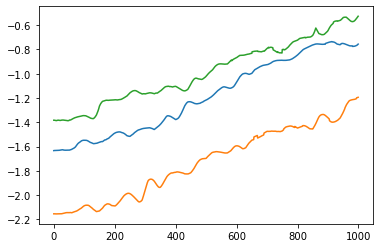

In [27]:
plt.plot(Energy[0])
plt.plot(Energy[1])
plt.plot(Energy[2])

tensor([94.7268,  8.2568], dtype=torch.float64, grad_fn=<SelectBackward>)

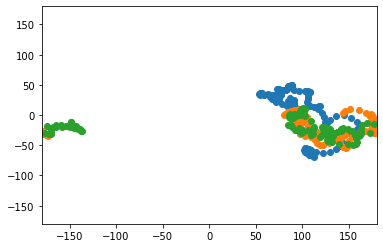

In [28]:
plt.scatter(S[:,0,0].detach(),S[:,0,1].detach())
plt.scatter(S[:,1,0].detach(),S[:,1,1].detach())
plt.scatter(S[:,2,0].detach(),S[:,2,1].detach())
plt.xlim([-180,180])
plt.ylim([-180,180])
S[0,0]

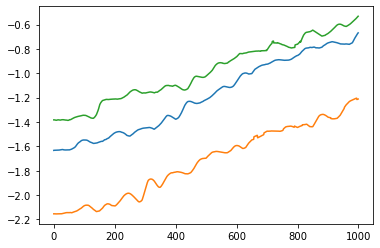

In [32]:
plt.plot(Energy[0])
plt.plot(Energy[1])
plt.plot(Energy[2])

tensor([94.7268,  8.2568], dtype=torch.float64, grad_fn=<SelectBackward>)

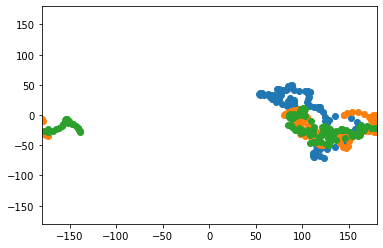

In [33]:
plt.scatter(S[:,0,0].detach(),S[:,0,1].detach())
plt.scatter(S[:,1,0].detach(),S[:,1,1].detach())
plt.scatter(S[:,2,0].detach(),S[:,2,1].detach())
plt.xlim([-180,180])
plt.ylim([-180,180])
S[0,0]

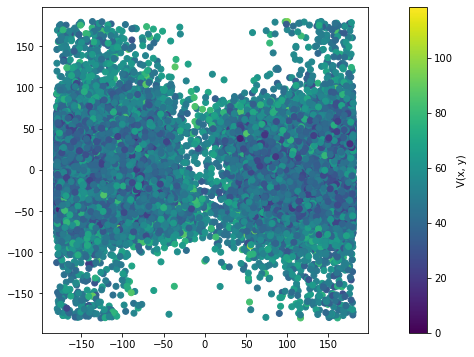

In [106]:
Z=dset.props['energy']
X,Y=ch.cat(dset.props['phi_psi'])[:,0],ch.cat(dset.props['phi_psi'])[:,1]
cmap = cm.get_cmap("viridis")
norm = cm.colors.Normalize(vmin=ch.min(Z), vmax=ch.max(Z))
scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)
c = scalarMap.to_rgba(Z)

fig, (ax, cax) = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': (0.9, 0.05)})

ax.scatter(X, Y, c=c, cmap=cmap)

#xtrain, ytrain = dset.x[:, 0], dset.x[:, 1]
#ax.scatter(xtrain, ytrain, c='w', linewidths=0.5, edgecolors='k')
ax.set_aspect('equal')

cbar = fig.colorbar(scalarMap, cax=cax, orientation='vertical')
cbar.set_label('V(x, y)')

plt.show()

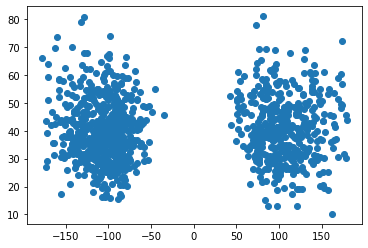

In [128]:
plt.scatter(X[abs(Y)<0.3334],Z[abs(Y)<0.3334])

In [125]:
Y<=0.3335

tensor([ True,  True, False,  ..., False,  True,  True])

In [123]:
Y

tensor([  0.3334, -34.1370,  31.9746,  ...,  25.3515,  -0.6305,  -7.4036])